In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM
from keras.layers import Activation, GlobalMaxPool2D, SpatialDropout2D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import gc

In [ ]:
sampling_rate = 128
window_size = 256
skip = 16
channel_len = 32
classes=3

bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 45/(sampling_rate/2)]}

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


200

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

## **Loading Data**

In [ ]:
eeg_signal = []
valence = []
arousal = []
dominance = []
signal_freq = []

for person in range(2,3):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<4] = 0
  label[(label>=4) & (label<6)] = 1
  label[(label>=6) & (label<=9)] = 2     

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label
  dom = label.T[2] # Dominance label

  del data, label
  

  for i in range(40): # Iterating through 40 vidoes/trials

    sig = eeg[i].T
    sig = sig[384:, :32] # Considering all 32 EEG channels

    ## Dividing Delta Band
    num, den = signal.butter(4, bands['delta'], 'bandpass') # Butterworth filter of order N = 4
    band_signal = signal.filtfilt(num, den, sig, axis=0)
    signal_freq.append(band_signal)

    ## Dividing Theta Band
    num, den = signal.butter(4, bands['theta'], 'bandpass')
    band_signal = signal.filtfilt(num, den, sig, axis=0)
    signal_freq.append(band_signal)

    ## Dividing Alpha Band
    num, den = signal.butter(4, bands['alpha'], 'bandpass')
    band_signal = signal.filtfilt(num, den, sig, axis=0)
    signal_freq.append(band_signal)

    ## Dividing Beta Band
    num, den = signal.butter(4, bands['beta'], 'bandpass')
    band_signal = signal.filtfilt(num, den, sig, axis=0)
    signal_freq.append(band_signal)
    
    ## Dividing Gamma Band
    num, den = signal.butter(4, bands['gamma'], 'bandpass')
    band_signal = signal.filtfilt(num, den, sig, axis=0)
    signal_freq.append(band_signal)
    del band_signal, num, den
    
 
  signal_freq_f = np.array(signal_freq) 
  signal_freq_f = np.reshape(signal_freq_f,[-1,160,7680])

  # Segmenting into 2 seconds (256 timesteps) windows with 1.875 seconds overlap
  start = 0
  while start + window_size <=signal_freq_f.shape[2]:
    eeg_signal.append(signal_freq_f[:, :, start:start+window_size])
    start += skip 
 
  for i in range(40):
    v = val[i]
    a = aro[i]
    d = dom[i]
    start = 0
    while start + window_size <=signal_freq_f.shape[2]:
      valence.append(v)
      arousal.append(a)
      dominance.append(d)
      start += skip


eeg_signal = np.reshape(eeg_signal,[-1,160,256])

data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)
dominance = np.asarray(dominance, dtype = np.int8)

del eeg_signal,signal_freq,signal_freq_f

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape, valence[valence==2].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape, arousal[arousal==2].shape)
print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape, dominance[dominance==2].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
dominance = np_utils.to_categorical(dominance)


Person No.2
(18600, 160, 256)
(18600,) (4185,) (5115,) (9300,)
(18600,) (6045,) (2790,) (9765,)
(18600,) (5115,) (2325,) (11160,)


In [ ]:
eeg_signal = []
valence = []
arousal = []
dominance = []
signal_freq = []
eeg_sig = []
gc.collect()

for person in range(2,3):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<4] = 0
  label[(label>=4) & (label<6)] = 1
  label[(label>=6) & (label<=9)] = 2     

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label
  dom = label.T[2] # Dominance label

  del data, label 

  for i in range(40): # Iterating through 40 vidoes/trials

    sig = eeg[i]
    sig = sig[:32, 384:]
    
    eeg_signal_temp = []
    for j in range(32):
      dfs = []
      ## Dividing Delta Band
      num, den = signal.butter(4, bands['delta'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))
      ## Dividing Theta Band
      num, den = signal.butter(4, bands['theta'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:])) 
      ## Dividing Alpha Band
      num, den = signal.butter(4, bands['alpha'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))
      ## Dividing Beta Band
      num, den = signal.butter(4, bands['beta'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))
      ## Dividing Gamma Band
      num, den = signal.butter(4, bands['gamma'], 'bandpass')
      dfs.append(signal.filtfilt(num, den, sig[j,:]))
      sig1 = np.array(dfs)
      sig1 = sig1.reshape([-1,7680])
      eeg_signal_temp.append(sig1)

    sig1 = np.array(eeg_signal_temp)
    sig1 = sig1.reshape([-1,7680])
    eeg_signal.append(sig1)
  del dfs, sig, sig1, eeg, eeg_signal_temp
  eeg_signal = np.reshape(eeg_signal,[-1,160,7680])
  gc.collect()
  for i in range(40):
    v = val[i]
    a = aro[i]
    d = dom[i]
    start = 0
    # Segmenting into 2 seconds (256 timesteps) windows with 1.75 seconds overlap
    while start + window_size <=eeg_signal.shape[3]:
      eeg_sig.append(eeg_signal[i, :, start:start+window_size])
      valence.append(v)
      arousal.append(a)
      dominance.append(d)
      start += skip

gc.collect()
del eeg_signal
eeg_sig = np.reshape(eeg_sig,[-1,160,256])
data = np.asarray(eeg_sig, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_sig
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)
dominance = np.asarray(dominance, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape, valence[valence==2].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape, arousal[arousal==2].shape)
print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape, dominance[dominance==2].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
dominance = np_utils.to_categorical(dominance)
print(valence.shape)
print(arousal.shape)
print(dominance.shape)

# **Finding Spectral Power**

In [ ]:
def spectral_power_fft(x, Fs):
    N = len(x)
    #PSD
    X = (2/(Fs*N)) * np.square(np.abs(np.fft.fft(x)))
    X = X[:N//2]
    SUM = np.sum(X)
    return SUM

In [ ]:
eeg_data = np.zeros((data.shape[0],data.shape[1]))
Fs = 128
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    eeg_data[i, j] = spectral_power_fft(data[i, j, :], Fs)
del data
data = np.reshape(eeg_data,[eeg_data.shape[0],eeg_data.shape[1],1])
del eeg_data
print(data.shape)
gc.collect()

# **CNN MODEL**

In [ ]:
def get_model() :
    input_shape = (data.shape[1],1)
    model=Sequential()
    model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128,kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64,kernel_size=3, strides=1, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32,activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3,activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
    return model


In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 160, 128)          512       
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 80, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            2

In [ ]:
batch_size = 128
epochs = 30
kfold = KFold(10, True, 1)
gc.collect()

170

# **Training (Valence)**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data,valence, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(14880, 160, 1) (3720, 160, 1) (14880, 3) (3720, 3)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
105/105 [==============================] - 34s 30ms/step - loss: 1.1015 - accuracy: 0.4419 - val_loss: 1.0369 - val_accuracy: 0.4946
Epoch 2/30
105/105 [==============================] - 2s 19ms/step - loss: 1.0481 - accuracy: 0.4678 - val_loss: 1.0143 - val_accuracy: 0.4886
Epoch 3/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0303 - accuracy: 0.4842 - val_loss: 0.9981 - val_accuracy: 0.4993
Epoch 4/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0166 - accuracy: 0.4844 - val_loss: 0.9774 - val_accuracy: 0.5027
Epoch 5/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0047 - accuracy: 0.4930 - val_loss: 0.9620 - val_accuracy: 0.5094
Epoch 6/30
105/105 [==============================] - 2s 18ms/step - loss: 0.9879 - accuracy: 0.5043 - val_loss: 0.9490 - val_accuracy: 0.5121
Epoch 7/30
105/105 [==============================] - 2s 19ms/step - loss: 0.9807 - accuracy: 0.5068 - val_loss: 0.9348 - 

117/117 [==============================] - 1s 5ms/step - loss: 0.2111 - accuracy: 0.9177
Accuracy  : 0.9177419543266296
F1_Score  : 0.9000399518989002


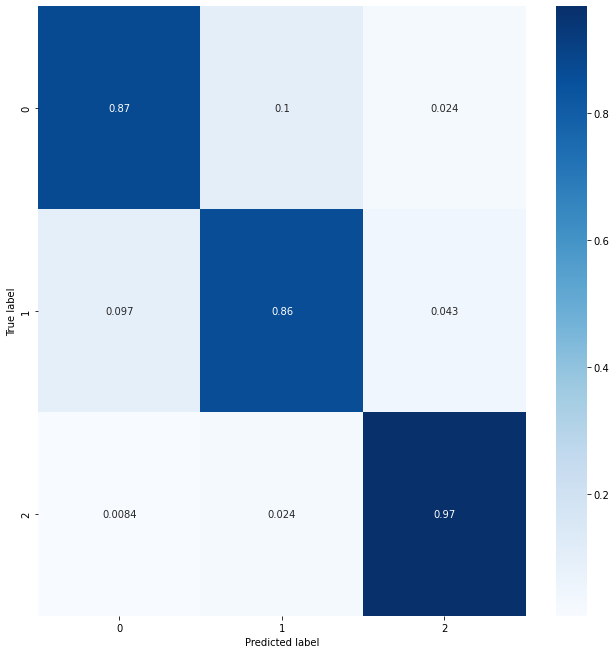

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# BorderLine SMOTE Augmentation(Valence)

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
import collections

data_aug, valence_aug = BorderlineSMOTE().fit_resample(np.reshape(data,[data.shape[0],data.shape[1]]), valence)
data_aug = np.reshape(data_aug,[data_aug.shape[0],data_aug.shape[1], 1])
print(data_aug.shape,valence_aug.shape)
print(valence_aug.shape)
gc.collect()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(27900, 160, 1) (27900, 3)
(27900, 3)


564

# **Training (Valence) with Augmentation**

In [ ]:
#valence_aug
X_train, x_test, Y_train, y_test = train_test_split(data_aug,valence_aug, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(22320, 160, 1) (5580, 160, 1) (22320, 3) (5580, 3)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
157/157 [==============================] - 6s 29ms/step - loss: 1.1515 - accuracy: 0.3506 - val_loss: 1.0784 - val_accuracy: 0.3862
Epoch 2/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0998 - accuracy: 0.3757 - val_loss: 1.0519 - val_accuracy: 0.4633
Epoch 3/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0739 - accuracy: 0.4042 - val_loss: 1.0219 - val_accuracy: 0.4888
Epoch 4/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0497 - accuracy: 0.4250 - val_loss: 0.9876 - val_accuracy: 0.5009
Epoch 5/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0265 - accuracy: 0.4455 - val_loss: 0.9714 - val_accuracy: 0.5125
Epoch 6/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0034 - accuracy: 0.4667 - val_loss: 0.9441 - val_accuracy: 0.5488
Epoch 7/30
157/157 [==============================] - 3s 18ms/step - loss: 0.9845 - accuracy: 0.4820 - val_loss: 0.9176 - v

175/175 [==============================] - 1s 6ms/step - loss: 0.1325 - accuracy: 0.9529
Accuracy  : 0.9528673887252808
F1_Score  : 0.9527144825076334


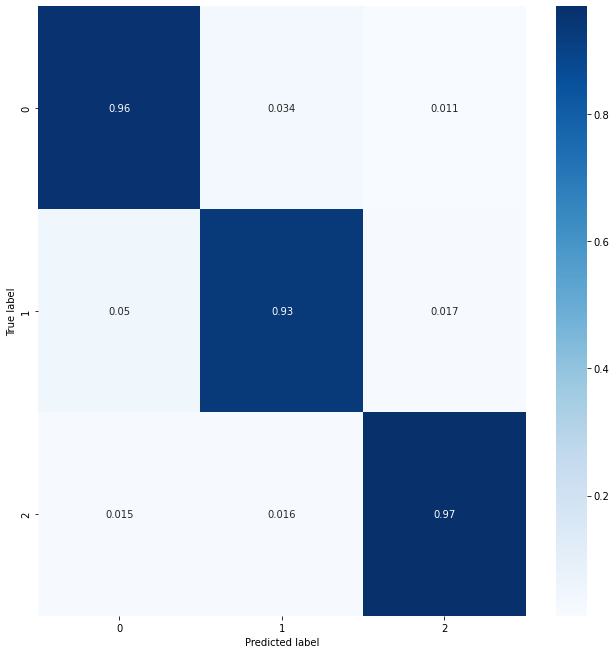

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(14880, 160, 1) (3720, 160, 1) (14880, 3) (3720, 3)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
105/105 [==============================] - 4s 23ms/step - loss: 1.1296 - accuracy: 0.4173 - val_loss: 1.0216 - val_accuracy: 0.5067
Epoch 2/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0650 - accuracy: 0.4524 - val_loss: 1.0047 - val_accuracy: 0.5074
Epoch 3/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0479 - accuracy: 0.4694 - val_loss: 0.9906 - val_accuracy: 0.5202
Epoch 4/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0424 - accuracy: 0.4652 - val_loss: 0.9751 - val_accuracy: 0.5202
Epoch 5/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0216 - accuracy: 0.4854 - val_loss: 0.9708 - val_accuracy: 0.5181
Epoch 6/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0126 - accuracy: 0.4912 - val_loss: 0.9590 - val_accuracy: 0.5282
Epoch 7/30
105/105 [==============================] - 2s 18ms/step - loss: 1.0100 - accuracy: 0.4907 - val_loss: 0.9561 - v

117/117 [==============================] - 1s 5ms/step - loss: 0.2361 - accuracy: 0.9051
Accuracy  : 0.9051074981689453
F1_Score  : 0.8936065027620596


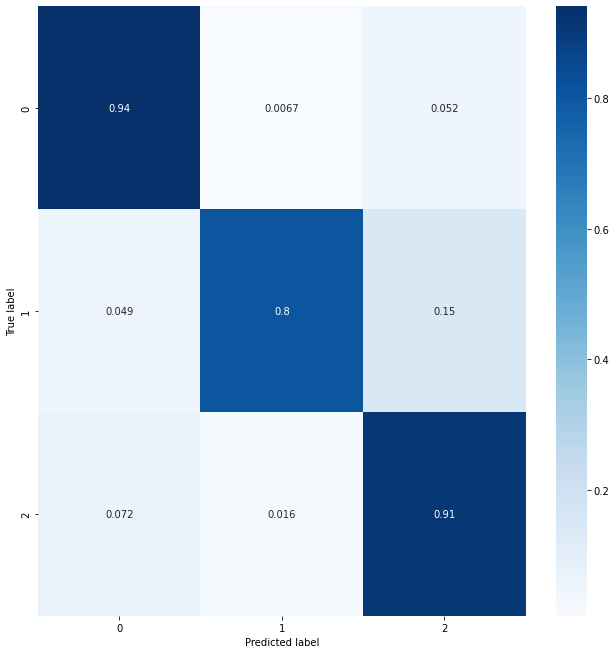

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **BorderLine SMOTE Augmentation (Arousal)**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
import collections

data_aug, arousal_aug = BorderlineSMOTE().fit_resample(np.reshape(data,[data.shape[0],data.shape[1]]), valence)
data_aug = np.reshape(data_aug,[data_aug.shape[0],data_aug.shape[1], 1])
print(data_aug.shape,valence_aug.shape)
print(arousal_aug.shape)
gc.collect()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(27900, 160, 1) (27900, 3)
(27900, 3)


4121

# **Training Arousal (with Augmentation)**

In [ ]:
#arousal_aug
X_train, x_test, Y_train, y_test = train_test_split(data_aug,arousal_aug, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(22320, 160, 1) (5580, 160, 1) (22320, 3) (5580, 3)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/30
157/157 [==============================] - 4s 20ms/step - loss: 1.1288 - accuracy: 0.3625 - val_loss: 1.0724 - val_accuracy: 0.4373
Epoch 2/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0806 - accuracy: 0.4056 - val_loss: 1.0478 - val_accuracy: 0.4601
Epoch 3/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0615 - accuracy: 0.4231 - val_loss: 1.0216 - val_accuracy: 0.4857
Epoch 4/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0404 - accuracy: 0.4496 - val_loss: 0.9894 - val_accuracy: 0.5103
Epoch 5/30
157/157 [==============================] - 3s 18ms/step - loss: 1.0211 - accuracy: 0.4688 - val_loss: 0.9786 - val_accuracy: 0.5336
Epoch 6/30
157/157 [==============================] - 3s 18ms/step - loss: 0.9967 - accuracy: 0.4869 - val_loss: 0.9324 - val_accuracy: 0.5502
Epoch 7/30
157/157 [==============================] - 3s 18ms/step - loss: 0.9818 - accuracy: 0.4980 - val_loss: 0.9173 - v

175/175 [==============================] - 1s 5ms/step - loss: 0.1181 - accuracy: 0.9561
Accuracy  : 0.9560931921005249
F1_Score  : 0.9559582654426556


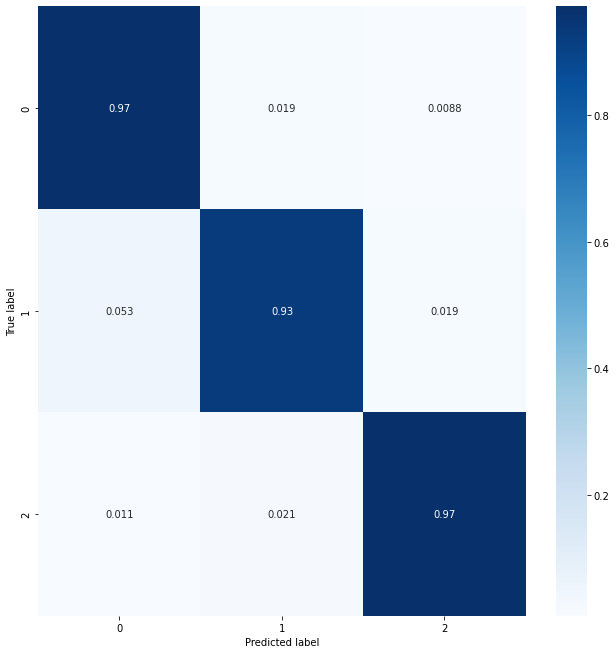

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()